# RFM Customer Segmentation — Jupyter Notebook

**Objective:** Build an end-to-end RFM (Recency, Frequency, Monetary) customer segmentation in Python using the Online Retail dataset.  

---

## Notebook outline
1. Setup & imports  
2. Get the data  
3. Quick EDA  
4. Data cleaning & preprocessing  
5. Feature engineering (TotalPrice)  
6. Build RFM table  
7. Score customers  
8. Create RFM segments (rule-based) + optional KMeans  
9. Visualizations  
10. Export results  
11. GitHub submission


## 1. Setup & imports


In [1]:
# !pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')

pd.options.display.float_format = '{:,.2f}'.format


## 2. Get the data

**Dataset:** Online Retail (UCI ML Repository).  
- Download the Excel file (`Online Retail.xlsx`) and keep it in the same folder as this notebook.  
- Or use a Kaggle mirror CSV.


In [2]:
import pandas as pd

# Try with ISO-8859-1
df = pd.read_csv("online_retail.csv", encoding="ISO-8859-1")

# OR
# df = pd.read_csv("online_retail.csv", encoding="latin1")

# Quick check
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


## 3. Quick EDA
- Inspect datatypes  
- Check missing CustomerID  
- Convert InvoiceDate to datetime  
- Look at top countries


In [3]:
# Dataset overview
df.info()

# Check top countries
print(df['Country'].value_counts().head())

# Missing values in CustomerID
print("Missing CustomerID:", df['CustomerID'].isna().sum())

# Ensure InvoiceDate is datetime
import numpy as np
if not np.issubdtype(df['InvoiceDate'].dtype, np.datetime64):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Quick peek
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64
Missing CustomerID: 135080


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 4. Data Cleaning
- Remove rows with missing CustomerID  
- Remove cancelled orders (InvoiceNo starting with 'C')  
- Remove negative quantities/prices  
- Create TotalPrice column


In [4]:
# Remove rows with missing CustomerID
df_clean = df.dropna(subset=['CustomerID']).copy()

# Keep only positive Quantity and UnitPrice
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Remove cancelled invoices (those starting with "C")
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Create a new column for total price
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Quick peek
df_clean.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## 5. Build RFM Table
- Recency = days since last purchase  
- Frequency = number of invoices  
- Monetary = total spent


In [5]:
# Snapshot date (1 day after last transaction)
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM values
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

# Rename columns
rfm.rename(columns={'InvoiceDate':'Recency',
                    'InvoiceNo':'Frequency',
                    'TotalPrice':'Monetary'}, inplace=True)

# Quick peek
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## 6. Score Customers
- Quantile scoring (1–5)  
- Recency reversed (lower → higher score)  
- Combine into RFM score


In [6]:
# Create R, F, M scores using quintiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Combine into overall RFM scores
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) + 
    rfm['F_Score'].astype(str) + 
    rfm['M_Score'].astype(str)
)

# Add numeric sum for easier segmentation
rfm['RFM_Sum'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

# Quick peek
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Sum
0,12346.0,326,1,77183.60,1,1,5,115,7
1,12347.0,2,7,4310.00,5,5,5,555,15
2,12348.0,75,4,1797.24,2,4,4,244,10
3,12349.0,19,1,1757.55,4,1,4,414,9
4,12350.0,310,1,334.40,1,1,2,112,4


## 7. Create RFM Segments (Rule-based)


In [7]:
def rfm_segmenter(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r == 5 and f >= 4 and m >= 4:
        return 'Champions'
    elif f >= 4 and r >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif r <= 2 and f >= 4:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Potential Loyalists'
    elif r <= 2 and m >= 4:
        return "Can't Lose"
    else:
        return 'Others'

# Apply segmentation
rfm['Segment'] = rfm.apply(rfm_segmenter, axis=1)

# Count how many customers in each segment
rfm['Segment'].value_counts()


Segment
Hibernating            1065
Loyal Customers         903
Others                  818
Champions               557
New Customers           319
Potential Loyalists     311
At Risk                 275
Can't Lose               90
Name: count, dtype: int64

## 8. Optional: Clustering with KMeans


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Prepare clustering data
rfm_clust = rfm[['Recency','Frequency','Monetary']].copy()
rfm_clust['Recency_log'] = np.log1p(rfm_clust['Recency'])
rfm_clust['Frequency_log'] = np.log1p(rfm_clust['Frequency'])
rfm_clust['Monetary_log'] = np.log1p(rfm_clust['Monetary'])

# Scale the log-transformed data
X = rfm_clust[['Recency_log','Frequency_log','Monetary_log']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# Show cluster counts
rfm['Cluster'].value_counts()


Cluster
3    1612
2    1173
0     837
1     716
Name: count, dtype: int64

## 9. Visualizations


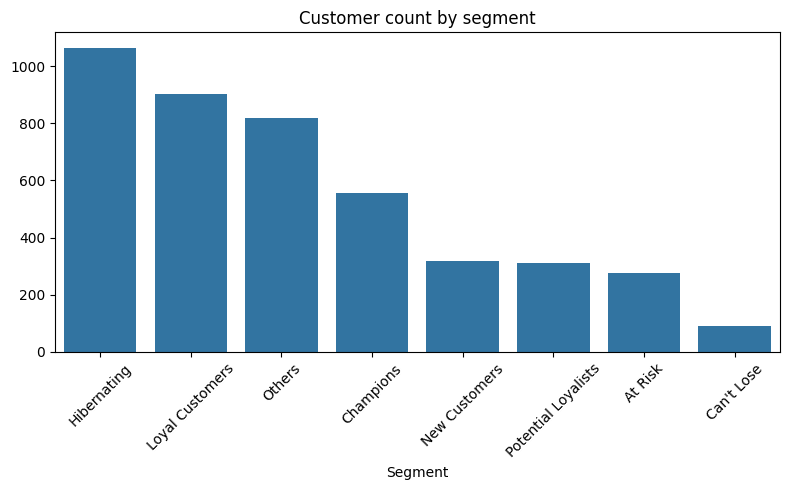

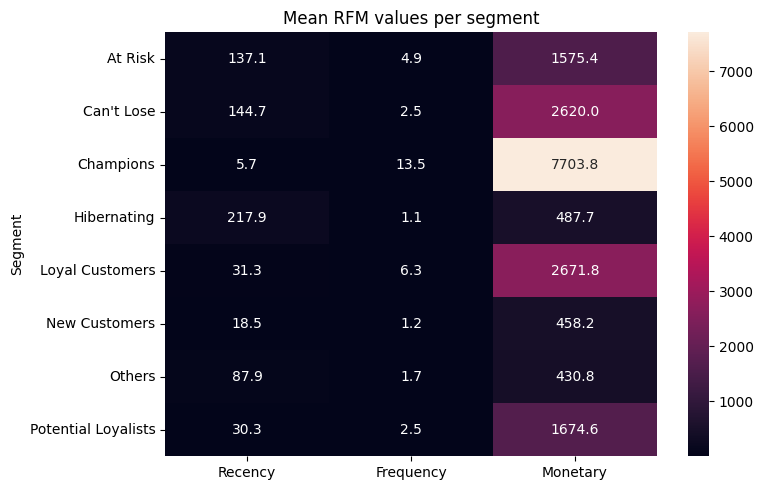

In [12]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Ensure 'graphs' folder exists ----
if not os.path.exists("graphs"):
    os.makedirs("graphs")

# ---- Graph 1: Customer count by segment ----
seg_counts = rfm['Segment'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=seg_counts.index, y=seg_counts.values)
plt.xticks(rotation=45)
plt.title("Customer count by segment")
plt.tight_layout()
plt.savefig("graphs/segment_count_barplot.png")  # Save graph
plt.show()

# ---- Graph 2: Mean RFM values per segment (heatmap) ----
rfm_stats = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()
plt.figure(figsize=(8,5))
sns.heatmap(rfm_stats, annot=True, fmt=".1f")
plt.title("Mean RFM values per segment")
plt.tight_layout()
plt.savefig("graphs/rfm_heatmap.png")  # Save graph
plt.show()


## 10. Export Results


In [11]:
rfm.to_csv("rfm_segments.csv", index=False)
print("Saved rfm_segments.csv")


Saved rfm_segments.csv


## 11. Marketing Actions

- **Champions** — VIP program, exclusive offers  
- **Loyal Customers** — Rewards, referral program  
- **New Customers** — Welcome campaigns  
- **At Risk** — Win-back offers  
- **Hibernating** — Re-engagement campaigns  
- **Can’t Lose** — Targeted high-value offers


## 12. GitHub Submission

**Suggested repo structure:**

```
rfm-customer-segmentation/
├─ data/ (include only sample or README)
├─ notebooks/ (this notebook)
├─ outputs/ (exported CSVs)
├─ README.md
├─ requirements.txt
```